<a href="https://colab.research.google.com/github/Darlywa/Sentiment-Analysis-CETM47/blob/main/cetm47_tweet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#/content/drive/MyDrive/Colab Notebooks/CETM47-22_23-AS2-Data.json

In [ ]:
#CETM 47 Assignment 2 - Tweet Classification
#Student: Ifeanyi Emeagi

In [ ]:
#import libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.stem  import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Download the required modules
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#Read the tweet into a dataframe
filepath = "/content/drive/MyDrive/Colab Notebooks/CETM47-22_23-AS2-Data.json"
tweet_df = pd.read_json(filepath)

In [ ]:
#Inspect the dataframe
tweet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6443 entries, 0 to 6442
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   text        6443 non-null   object        
 1   date        6443 non-null   datetime64[ns]
 2   label       6443 non-null   int64         
 3   id          6443 non-null   int64         
 4   label_name  6443 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 251.8+ KB


The dataset contains 6443 instances and 5 features. The features consists of two objects, two integer variables and one datetime object. There is no null value in the dataset. And the columns are named text, date, label, id and label_name.

In [ ]:
#Examine the first five tweet
tweet_df.tail()

,text,date,label,id,label_name
6438,Praying for {{USERNAME}} family friends riding...,2021-08-29,3,1431979856120762370,daily_life
6439,"Etsy: {{USERNAME}} Hi there, I m sorry to hear...",2021-08-29,1,1432008666018942977,business_&_entrepreneurs
6440,Imagine how hard it is to be a Teume. Everyone...,2021-08-29,2,1432008666803097606,pop_culture
6441,Ride With Me - Mental Health Awareness Charity...,2021-08-29,2,1432069101753491456,pop_culture
6442,Prediction: The future of CX in {@McKinsey Com...,2021-08-29,1,1432099700614774784,business_&_entrepreneurs


In [ ]:
#Count the unique options in label_name
label_value_count = tweet_df.label_name.value_counts()
label_value_count

pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: label_name, dtype: int64

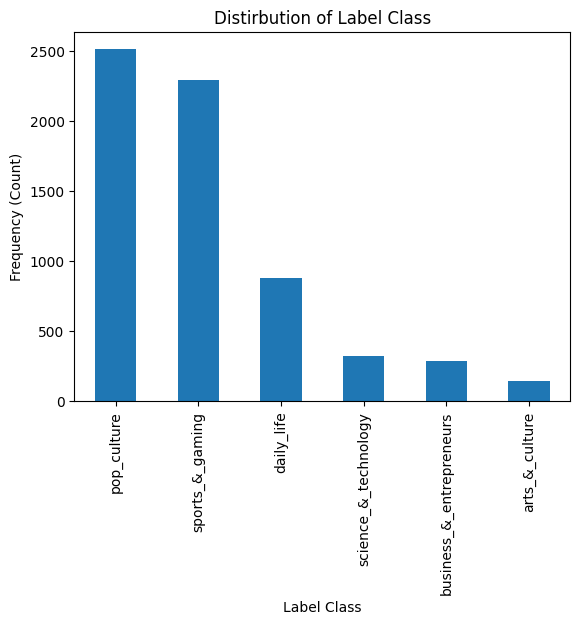

In [ ]:
label_value_count.plot(kind="bar")
plt.xlabel("Label Class")
plt.ylabel("Frequency (Count)")
plt.title("Distirbution of Label Class");

From the graph above, the dataset is not evenly distributed among the classes. pop_culture and sports_&_gaming have the highest number of tweet messages. To reduce the effect of the data imbalance on the model, I will ensure both the training and test data contains equal proportion of each class by using the stratified split module from scikit-learn to split the dataset.

I will define a function that will split the dataset putting into consideration the class label imbalance. Hence, the split will ensure that each of the class labels are present in both train and test set in equal proportion with respect to the split ratio.

The function will also match the label_names with the corresponding label.

In [ ]:
def loader(filepath):
  """This functions reads in the json file, identify the label name and its number,
  split the dataset in equal proportion of its label class

  Parameters
  ==========
  Input: str

  Return
  ======
  Output: pd.DataFrame, pd.Series, dict, 
  """
  tweet_df = pd.read_json(filepath)

  #Identify the label that represents each label name
  label_dict = {}
  unique_label_names = tweet_df.label_name.unique()
  for label in unique_label_names:
    label_number = tweet_df.loc[tweet_df["label_name"] == label, "label"].iloc[0]
    label_dict[label] = label_number

  #Select the text column and label column
  text_label = tweet_df[["text", "label"]]

  #Shuffle the dataframe
  split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 42)
  for train_index, test_index in split.split(text_label, text_label["label"]):
    stratified_train_set = text_label.loc[train_index]
    stratified_test_set = text_label.loc[test_index]

  stratified_X_train = stratified_train_set.drop(columns = "label", axis = 1)
  stratified_X_train = stratified_X_train.iloc[:, 0].tolist()
  stratified_y_train = stratified_train_set["label"]

  stratified_X_test = stratified_test_set.drop(columns = "label", axis = 1)

  stratified_y_test = stratified_test_set["label"]
  stratified_X_test = stratified_X_test.iloc[:, 0].tolist()
  return stratified_X_train, stratified_X_test, stratified_y_train, stratified_y_test, label_dict

In [ ]:
stratified_X_train, stratified_X_test, stratified_y_train, stratified_y_test, label_dict = loader(filepath)

In [ ]:
#The percentage of each class in train set.
stratified_y_train.value_counts()/len(stratified_y_train)

2    0.389794
4    0.355646
3    0.136981
5    0.050640
1    0.044626
0    0.022313
Name: label, dtype: float64

In [ ]:
#The perecntage of each class in test set
stratified_y_test.value_counts()/len(stratified_y_test)

2    0.390225
4    0.355314
3    0.137316
5    0.050427
1    0.044220
0    0.022498
Name: label, dtype: float64

In [ ]:
#The match between the label_name and the label. 
label_dict

{'sports_&_gaming': 4,
 'pop_culture': 2,
 'daily_life': 3,
 'business_&_entrepreneurs': 1,
 'science_&_technology': 5,
 'arts_&_culture': 0}

Define data preprocessing classes. This will consists of baselineText, addSteming and addLemmatization. The baseline class object will remove special characters, punctuations, stop-words and tokenize each sentence while the addSteming will stem the tokenized sentence and the addlemmatization will lemmatize the tokenized sentence.

The classes will inherit the property of BaseEstimator and TransformerMixin to enable them conform with scikit learn library format and fit into pipeline with other modules.

The will help standardized the process and enusre uniformity across each testing stage. It will also eliminate human errors in terms of ommission, since the whole process are chained in a pipeline.

In [ ]:
class baselineText(BaseEstimator, TransformerMixin):

  def __init__(self, language = "english"):
    self.language = language
    self.stopwords = set(nltk.corpus.stopwords.words(language))

  def stop_words(self, word):
    return word.lower() in self.stopwords

  def clean_tokenize(self, tweet):
    tweet =  re.sub(r'[^\w\s]', '', tweet.lower())
    tokenized_tweet = []
    for word in nltk.word_tokenize(tweet):
      if not self.stop_words(word):
        tokenized_tweet.append(word)
    return tokenized_tweet
  
  def fit(self, X, y=None):
    return self

  def transform(self, tweets):
    for tweet in tweets:
      yield self.clean_tokenize(tweet)


In [ ]:
class addStemming(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.stemmer = PorterStemmer()

  def preprocess(self, tweet):
    return [self.stemmer.stem(word) for word in tweet]
  
  def fit(self, X, y=None):
    return self

  def transform(self, tweets):
    for tweet in tweets:
      yield self.preprocess(tweet)

In [ ]:
class addLemmatization(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()

  def preprocess(self, tweet):
    return [self.lemmatizer_func(word, pos_tag)
          for word in tweet]

  def lemmatizer_func(self, word, pos_tag):
    mapping = {'N': wn.NOUN, 'V': wn.VERB, 'R': wn.ADV,'J': wn.ADJ}
    pos_tags = pos_tag([word])
    wn_pos_tags = [(word, mapping.get(tag[0].upper(), wn.NOUN)) for (word, tag) in pos_tags]
    word = wn_pos_tags[0][0]
    tag = wn_pos_tags[0][1]
    return self.lemmatizer.lemmatize(word, tag)
  
  def fit(self, X, y=None):
    return self

  def transform(self, tweets):
    for tweet in tweets:
      yield self.preprocess(tweet)

In [ ]:
print("The original text instance:")
stratified_X_train[0]

The original text instance:


'Second show of the day - {{USERNAME}} and {{USERNAME}}  The Boy Next Door  at {@Crazy Coqs@}'

In [ ]:

#baseline preprocessing
baseline = baselineText()
baseline_output = baseline.transform(stratified_X_train)

print("The baseline output:")
print(next(baseline_output))

The baseline output:
['second', 'show', 'day', 'username', 'username', 'boy', 'next', 'door', 'crazy', 'coqs']


In [ ]:
#baseline preprocessing
baseline = baselineText()
baseline_output = baseline.transform(stratified_X_train)

#Stemming the processed baseline
stem = addStemming()
stem_output = stem.transform(baseline_output)

print("The stemmed baseline:")
print(next(stem_output))

The stemmed baseline:
['second', 'show', 'day', 'usernam', 'usernam', 'boy', 'next', 'door', 'crazi', 'coq']


In [ ]:
#baseline preprocessing
baseline = baselineText()
baseline_output = baseline.transform(stratified_X_train)

#Lemmatizing the processed baseline
lemma = addLemmatization()
lemma_output = lemma.transform(baseline_output)

print("The lemmatized baseline:")
print(next(lemma_output))

The lemmatized baseline:
['second', 'show', 'day', 'username', 'username', 'boy', 'next', 'door', 'crazy', 'coqs']


In [ ]:
#A special case of adding both stemming and lemmatization object

#baseline preprocessing
baseline = baselineText()
baseline_output = baseline.transform(stratified_X_train)

#Stemming the processed baseline
stem = addStemming()
stem_output = stem.transform(baseline_output)

#Lemmatizing the processed baseline
lemma = addLemmatization()
lemma_output = lemma.transform(stem_output)

print("The lemmatized baseline:")
print(next(lemma_output))

The lemmatized baseline:
['second', 'show', 'day', 'usernam', 'usernam', 'boy', 'next', 'door', 'crazi', 'coq']


In [ ]:
#Create the pipeline

def create_pipeline(classifier, stem=False, lemmatize=False, tfidf=False):
  """The function creates the model pipeline. At default, the text processor 
  utilizes the baseline object

  Parameter
  =========
  Input: model, boolean

  Return:
  ======
  Output: sklearn pipeline
  """

  steps = [("baseline", baselineText())]

  if stem:
    #Add the stemming process
    steps.append(("stem", addStemming()))

  elif lemmatize:
    #Add the lemmatization process
    steps.append(("lemmatize", addLemmatization()))

  elif (stem & lemmatize):
    #Add both the stemming and the lemmatization process
    steps.append(("stem", addStemming()))
    steps.append(("lemmatize", addLemmatization()))
  else:
    pass

  if tfidf:
    #Add the TFIDF vectorizer
    steps.append(("tfidf_vectorizer", TfidfVectorizer(tokenizer=(lambda x: x), preprocessor=None, lowercase=False)))
  else:
    #Add the count vectorizer
    steps.append(("count_vectorizer", CountVectorizer(tokenizer=(lambda x: x), preprocessor=None, lowercase=False)))

  #Add the classifier
  steps.append(("classifier", OneVsRestClassifier(classifier)))

  return Pipeline(steps)

In [ ]:
#Build for one model and extend it to accomodate other model testing
stages = ["baseline", "stem", "lemmatization", "stem_&_lemma"]

stage_pipeline = []
for stage in stages:
  if stage == "baseline":
    #create and append the baseline pipeline using the count vect
    stage_pipeline.append(create_pipeline(MultinomialNB()))

  elif stage == "stem":
    #create a new pipeline by adding stem to the baseline pipeline
    stage_pipeline.append(create_pipeline(MultinomialNB(), stem = True))

  elif stage == "lemmatization":
    #create a new pipeline by adding lemma to the baseline pipeline
    stage_pipeline.append(create_pipeline(MultinomialNB(), lemmatize=True))

  elif stage == "stem_&_lemma":
    #create a new pipeline by adding stem and lemma to the baseline pipeline
    stage_pipeline.append(create_pipeline(MultinomialNB(), stem=True, lemmatize=True))


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=True)
for train_index, test_index in skfolds.split(stratified_X_train, stratified_y_train):
  clone_model = clone(stage_pipeline[0])
  stratified_X_train = np.array(stratified_X_train)
  stratified_y_train = np.array(stratified_y_train)
  X_train_fold = stratified_X_train[train_index] 
  y_train_fold = stratified_y_train[train_index]

  X_test_fold = stratified_X_train[np.array(test_index)]
  y_test_fold = stratified_y_train[np.array(test_index)]

  #fit the model
  clone_model.fit(X_train_fold, y_train_fold)


  #Extract the steps in the pipeline
  baseline = clone_model.named_steps["baseline"]
  vectorizer = clone_model.named_steps["count_vectorizer"]
  classifier = clone_model.named_steps["classifier"]

  #Transform the X_test_fold for classification
  base_output = baseline.transform(X_test_fold)
  vect_output = vectorizer.transform(base_output)

  #Predictions
  y_pred = classifier.predict(vect_output)

  #Accuracy
  accuracy = ((y_pred == y_test_fold).sum()/len(y_pred)).round(2)
  print(f"The acuracy for each cross validation fold is: {accuracy}")


The acuracy for each cross validation fold is: 0.79
The acuracy for each cross validation fold is: 0.79
The acuracy for each cross validation fold is: 0.78
The acuracy for each cross validation fold is: 0.78
The acuracy for each cross validation fold is: 0.79


In [ ]:
#Start with the first stage pipeline

#retrive the first stage pipeline
first_stage_pipeline = stage_pipeline[0]

#fit the pipeline
first_stage_pipeline.fit(stratified_X_train, stratified_y_train)

#Extract the steps in the pipeline
baseline = first_stage_pipeline.named_steps["baseline"]
vectorizer = first_stage_pipeline.named_steps["count_vectorizer"]
classifier = first_stage_pipeline.named_steps["classifier"]

#Transform the stratified_X_test for classification
base_output = baseline.transform(stratified_X_test)
vect_output = vectorizer.transform(base_output)

#Classify the transformed input
predicted_class = classifier.predict(vect_output)



In [ ]:
reverse_label_dict = {v: k for k, v in label_dict.items()}
classifier.classes_
[reverse_label_dict[i] for i in list(classifier.classes_)]

['arts_&_culture',
 'business_&_entrepreneurs',
 'pop_culture',
 'daily_life',
 'sports_&_gaming',
 'science_&_technology']

In [ ]:
#General accuracy
(stratified_y_test == predicted_class).sum()/len(predicted_class)

0.804499612102405

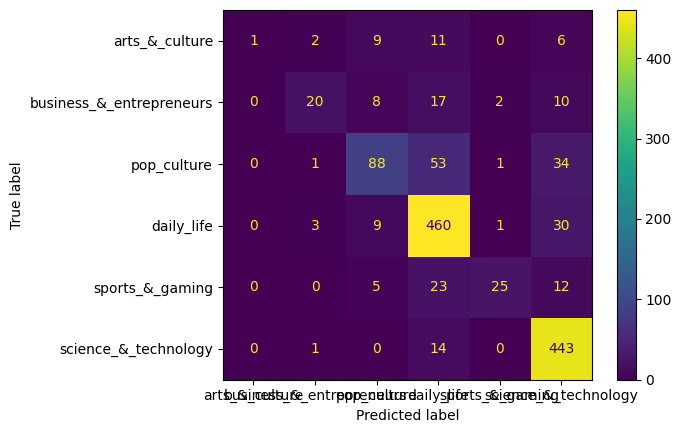

In [ ]:



#Transform the y_test and the predicted_class using their label name for easy readability
reverse_label_dict = {v: k for k, v in label_dict.items()}
labelled_stratified_y_test = [reverse_label_dict[label] for label in stratified_y_test]
labelled_predicted_class = [reverse_label_dict[label] for label in predicted_class]



#Evaluation

cm = confusion_matrix(labelled_stratified_y_test, labelled_predicted_class)
result_df = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN", "Accuracy", "Precision", "Recall", "F1_Score"])
tn_per_class = []
for i in range(cm.shape[0]):
    tp = cm[i,i]
    fp = cm[:,i].sum() - tp
    fn = cm[i,:].sum() - tp
    tn = cm.sum() - tp - fp - fn
    tn_per_class.append(tn)

    #Calculate the accuracy, precision, recall and f1 score
    accuracy = (tp + tn) / (tp + fp + fn +tn) 
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall)/(precision + recall)
    result_df.loc[i] = [reverse_label_dict[i], tp, fp, tn, fn, accuracy, precision, recall, f1_score]

#calculate the overall tp, fp, fn, tn and recompute the accuracy
t_tp = np.sum(np.diag(cm))
t_fp = np.sum(cm.sum(axis=0) - np.diag(cm))
t_fn = np.sum(cm.sum(axis=1) - np.diag(cm))
t_tn = np.mean(tn_per_class)

t_accuracy = (t_tp + t_tn) / (t_tp + t_fp + t_fn + t_tn)
t_precision = t_tp / (t_tp + t_fp)
t_recall = t_tp/ (t_tp + t_fn)
t_f1_score = (2 * t_precision * t_recall) / (t_precision + t_recall)

result_df.loc[len(result_df)] = ["Over-all", t_tp, t_fp, t_tn, t_fn, t_accuracy, t_precision, t_recall, t_f1_score]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [reverse_label_dict[i] for i in list(classifier.classes_)])
disp.plot()
plt.show()


In [ ]:
result_df

,Class,TP,FP,TN,FN,Accuracy,Precision,Recall,F1_Score
0,arts_&_culture,1,0,1260.0,28,0.978278,1.000000,0.034483,0.066667
1,business_&_entrepreneurs,16,4,1228.0,41,0.965089,0.800000,0.280702,0.415584
2,pop_culture,81,31,1081.0,96,0.901474,0.723214,0.457627,0.560554
3,daily_life,463,136,650.0,40,0.863460,0.772955,0.920477,0.840290
4,sports_&_gaming,20,1,1223.0,45,0.964313,0.952381,0.307692,0.465116
5,science_&_technology,443,93,738.0,15,0.916214,0.826493,0.967249,0.891348
6,Over-all,1024,265,1030.0,265,0.794892,0.794414,0.794414,0.794414


In [ ]:
#Compare the result above with the classification report

def result_generator(stratified_y_test, predicted_class, stage, model):
  """The function computes TP, FP, TN, FN Accuracy, Precision, Recall, F1_score for 
  each class label and the over-all class.

  parameters
  ===========
  Input: pd.Series, np.array, str

  Return
  =======
  Output: pd.DataFrame
  """

  #Transform the y_test and the predicted_class using their label name for easy readability
  reverse_label_dict = {v: k for k, v in label_dict.items()}
  labelled_stratified_y_test = [reverse_label_dict[label] for label in stratified_y_test]
  labelled_predicted_class = [reverse_label_dict[label] for label in predicted_class]

  #Evaluation

  cm = confusion_matrix(labelled_stratified_y_test, labelled_predicted_class)
  result_df = pd.DataFrame(columns=["model", "stage", "Class", "TP", "FP", "TN", "FN", "Accuracy", "Precision", "Recall", "F1_Score"])
  tn_per_class = []
  for i in range(cm.shape[0]):
    tp = cm[i,i]
    fp = cm[:,i].sum() - tp
    fn = cm[i,:].sum() - tp
    tn = cm.sum() - tp - fp - fn
    tn_per_class.append(tn)

    #Calculate the accuracy, precision, recall and f1 score
    accuracy = (tp + tn) / (tp + fp + fn +tn) 
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall)/(precision + recall)
    result_df.loc[i] = [model, stage, reverse_label_dict[i], tp, fp, tn, fn, accuracy, precision, recall, f1_score]

    #calculate the overall tp, fp, fn, tn and recompute the accuracy
  t_tp = np.sum(np.diag(cm))
  t_fp = np.sum(cm.sum(axis=0) - np.diag(cm))
  t_fn = np.sum(cm.sum(axis=1) - np.diag(cm))
  t_tn = np.mean(tn_per_class)

  t_accuracy = (t_tp + t_tn) / (t_tp + t_fp + t_fn + t_tn)
  t_precision = t_tp / (t_tp + t_fp)
  t_recall = t_tp/ (t_tp + t_fn)
  t_f1_score = (2 * t_precision * t_recall) / (t_precision + t_recall)

  result_df.loc[len(result_df)] = [model, stage, "Over-all", t_tp, t_fp, t_tn, t_fn, t_accuracy, t_precision, t_recall, t_f1_score]
  
  return result_df


In [ ]:
classifiers = (MultinomialNB, SGDClassifier, RandomForestClassifier)
stages = ["baseline", "stem", "lemmatization", "stem_&_lemma"]

models_dict = {}

for classifier in classifiers:
  pipeline_holder = []
  for stage in stages:
    if stage == "baseline":
      #create and append the baseline pipeline using the count vect
      pipeline_holder.append(create_pipeline(classifier()))

    elif stage == "stem":
      #create a new pipeline by adding stem to the baseline pipeline
      pipeline_holder.append(create_pipeline(classifier(), stem = True))

    elif stage == "lemmatization":
      #create a new pipeline by adding lemma to the baseline pipeline
      pipeline_holder.append(create_pipeline(classifier(), lemmatize=True))

    elif stage == "stem_&_lemma":
      #create a new pipeline by adding stem and lemma to the baseline pipeline
      pipeline_holder.append(create_pipeline(classifier(), stem=True, lemmatize=True))
  models_dict[str(classifier)] = pipeline_holder

In [ ]:
#This will fit the three classifiers under 4 different stages using count vectoriser and evaluate the 
#the test result. 

model_report_table = []
m = 0
for key, models in models_dict.items():
  i = 0
  report_list = []
  for pipeline in models:

    #fit the pipeline
    pipeline.fit(stratified_X_train, stratified_y_train)

    #Extract the classifier object
    classifier = pipeline.named_steps["classifier"]

    #Extract the data preprocessor
    preprocessor = pipeline.steps[0][1]

    #Extract the vectorizer
    vectorizer = pipeline.named_steps["count_vectorizer"]

    #Process the stratified_X_test
    X_test_preprocessed = preprocessor.transform(stratified_X_test)

    #Vectorized the preprocessed test set
    X_test_vectorized = vectorizer.transform(X_test_preprocessed)

    #Classify the test set
    predicted_class = classifier.predict(X_test_vectorized)
    report = result_generator(stratified_y_test, predicted_class, stages[i], classifiers[m])
    report_list.append(report)
    #Increment the stage counter
    i += 1
  concatenate_df = pd.concat(report_list)
  #Increment the classifier counter
  m += 1
  model_report_table.append(concatenate_df)
final_result_table = pd.concat(model_report_table)

In [ ]:
final_result_table.head(32)

,model,stage,Class,TP,FP,TN,FN,Accuracy,Precision,Recall,F1_Score
0,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,arts_&_culture,1,0,1260.000000,28,0.978278,1.000000,0.034483,0.066667
1,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,business_&_entrepreneurs,20,7,1225.000000,37,0.965865,0.740741,0.350877,0.476190
2,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,pop_culture,88,31,1081.000000,89,0.906905,0.739496,0.497175,0.594595
3,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,daily_life,460,118,668.000000,43,0.875097,0.795848,0.914513,0.851064
4,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,sports_&_gaming,25,4,1220.000000,40,0.965865,0.862069,0.384615,0.531915
5,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,science_&_technology,443,92,739.000000,15,0.916990,0.828037,0.967249,0.892246
6,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,Over-all,1037,252,1032.166667,252,0.804132,0.804500,0.804500,0.804500
0,<class 'sklearn.naive_bayes.MultinomialNB'>,stem,arts_&_culture,1,0,1260.000000,28,0.978278,1.000000,0.034483,0.066667
1,<class 'sklearn.naive_bayes.MultinomialNB'>,stem,business_&_entrepreneurs,13,7,1225.000000,44,0.960434,0.650000,0.228070,0.337662
2,<class 'sklearn.naive_bayes.MultinomialNB'>,stem,pop_culture,54,33,1079.000000,123,0.878976,0.620690,0.305085,0.409091


In [ ]:
def experiment(tfidf=False):

  classifiers = (MultinomialNB, SGDClassifier, RandomForestClassifier)
  stages = ["baseline", "stem", "lemmatization", "stem_&_lemma"]

  models_dict = {}

  for classifier in classifiers:
    pipeline_holder = []
    for stage in stages:
      if stage == "baseline":
        #create and append the baseline pipeline using the count vect
        pipeline_holder.append(create_pipeline(classifier(), tfidf=tfidf))

      elif stage == "stem":
        #create a new pipeline by adding stem to the baseline pipeline
        pipeline_holder.append(create_pipeline(classifier(), stem = True, tfidf=tfidf))

      elif stage == "lemmatization":
        #create a new pipeline by adding lemma to the baseline pipeline
        pipeline_holder.append(create_pipeline(classifier(), lemmatize=True, tfidf=tfidf))

      elif stage == "stem_&_lemma":
        #create a new pipeline by adding stem and lemma to the baseline pipeline
        pipeline_holder.append(create_pipeline(classifier(), stem=True, lemmatize=True, tfidf=tfidf))
    models_dict[str(classifier)] = pipeline_holder


  #This will fit the three classifiers under 4 different stages using selected vectoriser and evaluate the 
  #the test result. The default is count vectorizer

  model_report_table = []
  m = 0
  for key, models in models_dict.items():
    i = 0
    report_list = []
    for pipeline in models:

      #fit the the pipeline
      pipeline.fit(stratified_X_train, stratified_y_train)

      #Extract the classifier object
      classifier = pipeline.named_steps["classifier"]

      #Extract the data preprocessor
      preprocessor = pipeline.steps[0][1]

      #Extract the vectorizer
      if tfidf:
        vectorizer = pipeline.named_steps["tfidf_vectorizer"]
      else:
        vectorizer = pipeline.named_steps["count_vectorizer"]

      #Process the stratified_X_test
      X_test_preprocessed = preprocessor.transform(stratified_X_test)

      #Vectorized the preprocessed test set
      X_test_vectorized = vectorizer.transform(X_test_preprocessed)

      #Classify the test set
      predicted_class = classifier.predict(X_test_vectorized)
      report = result_generator(stratified_y_test, predicted_class, stages[i], classifiers[m])
      report_list.append(report)
      #Increment the stage counter
      i += 1
      concatenate_df = pd.concat(report_list)
    #Increment the classifier counter
    m += 1
    model_report_table.append(concatenate_df)
  #join the final result sheet
  final_result_table = pd.concat(model_report_table)

  #Write the result to excelsheet
  if tfidf:
    final_result_table.to_csv("tfidf.csv", index=False)
  else:
    final_result_table.to_csv("count_vect.csv", index=False)

  return final_result_table

To run the experiement using tfidf, I will set the tfidf to true else it will run with count vectorizer.

Also, the experiment on the premises that all the required arguments have been defined previous in the work page.

Finally, the experiement returns write the result sheet to a csv file using either the tfidf or the cout_vect as the file name and also returns the final result sheet as a dataframe.

The essence of this whole partial automation is to minimise human errors like ommission, etc. 

In [ ]:
#To run the experiment using tfidf, I will set tfidf to true else it will run with count vectorizer

In [ ]:
#Run the experiment with count vectorizer
cv_result_sheet = experiment()

In [ ]:
#Run the experiment with tfidf vectorizer
tfidf_result_sheet = experiment(tfidf=True)

In [ ]:
cv_result_sheet[cv_result_sheet["Class"] == "Over-all"]

,model,stage,Class,TP,FP,TN,FN,Accuracy,Precision,Recall,F1_Score
6,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,Over-all,1037,252,1032.166667,252,0.804132,0.804500,0.804500,0.804500
6,<class 'sklearn.naive_bayes.MultinomialNB'>,stem,Over-all,939,350,1015.833333,350,0.736330,0.728472,0.728472,0.728472
6,<class 'sklearn.naive_bayes.MultinomialNB'>,lemmatization,Over-all,1007,282,1027.166667,282,0.782924,0.781226,0.781226,0.781226
6,<class 'sklearn.naive_bayes.MultinomialNB'>,stem_&_lemma,Over-all,939,350,1015.833333,350,0.736330,0.728472,0.728472,0.728472
6,<class 'sklearn.linear_model._stochastic_gradi...,baseline,Over-all,1021,268,1029.500000,268,0.792770,0.792087,0.792087,0.792087
6,<class 'sklearn.linear_model._stochastic_gradi...,stem,Over-all,894,395,1008.333333,395,0.706574,0.693561,0.693561,0.693561
6,<class 'sklearn.linear_model._stochastic_gradi...,lemmatization,Over-all,970,319,1021.000000,319,0.757322,0.752521,0.752521,0.752521
6,<class 'sklearn.linear_model._stochastic_gradi...,stem_&_lemma,Over-all,907,382,1010.500000,382,0.715085,0.703646,0.703646,0.703646
6,<class 'sklearn.ensemble._forest.RandomForestC...,baseline,Over-all,1042,247,1033.000000,247,0.807707,0.808379,0.808379,0.808379
6,<class 'sklearn.ensemble._forest.RandomForestC...,stem,Over-all,940,349,1016.000000,349,0.737001,0.729247,0.729247,0.729247


In [ ]:
tfidf_result_sheet[tfidf_result_sheet["Class"] == "Over-all"]

,model,stage,Class,TP,FP,TN,FN,Accuracy,Precision,Recall,F1_Score
6,<class 'sklearn.naive_bayes.MultinomialNB'>,baseline,Over-all,935,354,1015.166667,354,0.733651,0.725369,0.725369,0.725369
6,<class 'sklearn.naive_bayes.MultinomialNB'>,stem,Over-all,890,399,1007.666667,399,0.703969,0.690458,0.690458,0.690458
6,<class 'sklearn.naive_bayes.MultinomialNB'>,lemmatization,Over-all,919,370,1012.500000,370,0.723002,0.712956,0.712956,0.712956
6,<class 'sklearn.naive_bayes.MultinomialNB'>,stem_&_lemma,Over-all,890,399,1007.666667,399,0.703969,0.690458,0.690458,0.690458
6,<class 'sklearn.linear_model._stochastic_gradi...,baseline,Over-all,1042,247,1033.000000,247,0.807707,0.808379,0.808379,0.808379
6,<class 'sklearn.linear_model._stochastic_gradi...,stem,Over-all,935,354,1015.166667,354,0.733651,0.725369,0.725369,0.725369
6,<class 'sklearn.linear_model._stochastic_gradi...,lemmatization,Over-all,1010,279,1027.666667,279,0.785026,0.783553,0.783553,0.783553
6,<class 'sklearn.linear_model._stochastic_gradi...,stem_&_lemma,Over-all,930,359,1014.333333,359,0.730312,0.721490,0.721490,0.721490
6,<class 'sklearn.ensemble._forest.RandomForestC...,baseline,Over-all,1027,262,1030.500000,262,0.797017,0.796742,0.796742,0.796742
6,<class 'sklearn.ensemble._forest.RandomForestC...,stem,Over-all,899,390,1009.166667,390,0.709839,0.697440,0.697440,0.697440
